### Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
import pickle
import hashlib
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from utils.models import model_mapping
from utils.evaluate import evaluate_model
from IPython.display import display, Markdown
from sklearn.exceptions import ConvergenceWarning

# suppressing OpenMP deprecation from LightGBM
os.environ["KMP_WARNINGS"] = "0"

# suppressing specific warnings by module filtering
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_selection._univariate_selection")
warnings.filterwarnings("ignore", category=UserWarning, module="umap.umap_")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Usage of np.ndarray subset.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite' was renamed.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered in divide.*")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# you could suppress ALL UserWarnings and RuntimeWarnings, but we might miss something (so let's not)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading Best Models

In [2]:
# configuration
dataset_names = ['rarefied', 'clr']
data_dir = "./data"
results_dir = "./results/summaries"
clr_visuals_dir = "./results/visuals/clr"
rarefied_visuals_dir = "./results/visuals/rarefied"
pickle_dir = "./results/pickles"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(clr_visuals_dir, exist_ok=True)
os.makedirs(rarefied_visuals_dir, exist_ok=True)
os.makedirs(pickle_dir, exist_ok=True)

# loading best models info
with open(f"{results_dir}/best_models.json", "r") as f:
    best_models_dict = json.load(f)

print("Loaded Best Models from Training:")
for dataset, model_info in best_models_dict.items():
    print(f"- {dataset}: {model_info['best_model']} (AUC = {model_info['metrics']['auc']})")

Loaded Best Models from Training:
- rarefied: Light Gradient Boosting Model (AUC = 0.78454)
- clr: Logistic Regression - Elastic Net (AUC = 0.77202)


### Loading Best Models & Defining Feature Selection & Extraction Utility Functions

In [3]:
def select_features(X_train, y_train, X_test, method, k=100):
    selector = SelectKBest(method, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected
    
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


### Finding Best Methods Utility Function

In [4]:
def find_best_method(feat_sel_results, feat_ext_results, dataset_name, model_name):
    best_auc = -1
    best_method_name = ""
    best_probs = None
    best_y_true = None
    best_k = None
    best_type = None

    all_results = {
        "Selection": feat_sel_results,
        "Extraction": feat_ext_results
    }

    for method_type, results_dict in all_results.items():
        for k, methods in results_dict.items():
            for method, metrics in methods.items():
                if metrics["AUC"] > best_auc:
                    best_auc = metrics["AUC"]
                    best_method_name = method
                    best_probs = metrics["y_probs"]
                    best_y_true = metrics["y_true"]
                    best_k = k
                    best_type = method_type

    best_preds = np.round(best_probs).astype(int)
    method_id = f"{dataset_name}_{model_name}_{best_method_name}_{best_k}"
    
    # evaluating for best method
    full_metrics = evaluate_model(best_y_true, best_preds, best_probs)
    
    return {
        "method": best_method_name,
        "n_features": best_k,
        "type": best_type,
        "AUC": full_metrics["AUC"],
        "Accuracy": full_metrics["Accuracy"],
        "Precision": full_metrics["Precision"],
        "Recall": full_metrics["Recall"],
        "F1": full_metrics["F1"],
        "y_probs": best_probs,
        "y_true": best_y_true,
        "y_preds": best_preds,
        "method_id": method_id
    }



### Feature Engineering Function

In [5]:
def run_feature_engineering(dataset_name):
    print(f"\n{'='*60}\n Running Feature Engineering on: {dataset_name}\n{'='*60}")

    # ====== 0. Pickle Setup ======
    # want to test or debug?          -> USE_PICKLE = False
    # want to use existing pickle?    -> USE_PICKLE = True, OVERWRITE_PICKLE = False
    # want to rerun & overwrite?      -> USE_PICKLE = True, OVERWRITE_PICKLE = True
    
    USE_PICKLE = True
    OVERWRITE_PICKLE = True

    pickle_path = os.path.join(pickle_dir,f"feature_eng_output_{dataset_name}.pkl")

    if USE_PICKLE and os.path.exists(pickle_path) and not OVERWRITE_PICKLE:
        if os.path.exists(pickle_path):
            print(f"Found pickle for {dataset_name}, loading instead of recomputing...")
            with open(pickle_path, "rb") as f:
                return pickle.load(f)

    # ====== 1. Preparing Data ======

    df = pd.read_csv(f"{data_dir}/{dataset_name}.csv", index_col=0)
    X = df.drop(columns=["Diagnosis", "Diagnosis_labeled"])
    y = df["Diagnosis_labeled"]

    le = LabelEncoder()
    y = le.fit_transform(y)

    # ====== 2. Setting Up Feature Counts and Model ======

    #feature_counts = [1] + list(range(10, 201, 10))
    #runs = 100
    feature_counts = [1, 50, 100, 200]  # uncomment for quick testing
    runs = 5  # uncomment for quick testing
    random_seeds = np.random.randint(0, 10000, size=runs)

    best_model_name = best_models_dict[dataset_name]["best_model"]
    if best_model_name not in model_mapping:
        raise ValueError(f"Model '{best_model_name}' not found in model_mapping")

    best_model = model_mapping[best_model_name]()

    # ====== 3. Initializing Storage ======

    selection_scores = {
        k: {m: [] for m in ["Chi-Squared", "Mutual Information", "ANOVA F-value"]}
        for k in feature_counts
    }
    extraction_scores = {
        k: {m: [] for m in ["UMAP", "PCA", "Kernel PCA"]}
        for k in feature_counts
    }

    selection_probs = {
        k: {m: {"y_probs": [], "y_true": []}
            for m in selection_scores[k]
        }
        for k in feature_counts
    }
    extraction_probs = {
        k: {m: {"y_probs": [], "y_true": []}
            for m in extraction_scores[k]
        }
        for k in feature_counts
    }

    baseline_probs_all = []
    y_test_all = []

    print("\nEvaluating Feature Engineering Methods:")

    # ====== 4. Looping Over Runs and Seeds ======

    for i, seed in enumerate(tqdm(random_seeds, desc="Feature Engineering Runs")):

        # ====== 4a. Train-Test Split, VarianceThreshold, Scaling ======

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
        
        vt = VarianceThreshold(threshold=0)
        X_train = vt.fit_transform(X_train)
        X_test = vt.transform(X_test)

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # ====== 4b. Baseline Evaluation (All Features) ======

        best_model.train(X_train, y_train)
        baseline_probs = best_model.model.predict_proba(X_test)[:, 1]

        baseline_probs_all.extend(baseline_probs)
        y_test_all.extend(y_test)

        for k in feature_counts:

            # ====== 4c. Feature Selection (Chi², MI, ANOVA) ======

            X_train_chi2, X_test_chi2 = select_features(X_train, y_train, X_test, chi2, k)
            X_train_mi, X_test_mi = select_features(X_train, y_train, X_test, mutual_info_classif, k)
            X_train_anova, X_test_anova = select_features(X_train, y_train, X_test, f_classif, k)

            for method, X_tr, X_te in zip(
                ["Chi-Squared", "Mutual Information", "ANOVA F-value"],
                [X_train_chi2, X_train_mi, X_train_anova],
                [X_test_chi2, X_test_mi, X_test_anova]):
                best_model.train(X_tr, y_train)
                probs = best_model.model.predict_proba(X_te)[:, 1]
                metrics = evaluate_model(y_test, probs.round(), probs)

                selection_scores[k][method].append(metrics)
                selection_probs[k][method]["y_probs"].extend(probs)
                selection_probs[k][method]["y_true"].extend(y_test)

            # ====== 4d. Feature Extraction (PCA, KPCA, UMAP) ======

            X_train_pca, X_test_pca = apply_pca(X_train, X_test, k)
            kpca = KernelPCA(n_components=k, kernel='rbf', random_state=42)
            X_train_kpca = kpca.fit_transform(X_train)
            X_test_kpca = kpca.transform(X_test)

            umap_reducer = umap.UMAP(n_components=k, random_state=42)
            X_train_umap = umap_reducer.fit_transform(X_train)
            X_test_umap = umap_reducer.transform(X_test)

            for method, X_tr, X_te in zip(
                ["PCA", "Kernel PCA", "UMAP"],
                [X_train_pca, X_train_kpca, X_train_umap],
                [X_test_pca, X_test_kpca, X_test_umap]):
                best_model.train(X_tr, y_train)
                probs = best_model.model.predict_proba(X_te)[:, 1]
                metrics = evaluate_model(y_test, probs.round(), probs)

                extraction_scores[k][method].append(metrics)
                extraction_probs[k][method]["y_probs"].extend(probs)
                extraction_probs[k][method]["y_true"].extend(y_test)

    # ====== 5. Averaging Metrics Across Runs ======

    def average_results(results_dict):
        averaged = {}
        for k, methods in results_dict.items():
            averaged[k] = {}
            for method, scores in methods.items():
                averaged[k][method] = {
                    metric: np.mean([m[metric] for m in scores])
                    for metric in
                    ["AUC", "Accuracy", "Precision", "Recall", "F1"]
                }
        return averaged

    feature_selection_results = average_results(selection_scores)
    feature_extraction_results = average_results(extraction_scores)
    
    # ====== 6. Adding Probabilities for ROC Curves ======

    for k, method_dict in selection_probs.items():
        for method, data in method_dict.items():
            feature_selection_results[k][method]["y_probs"] = np.array(data["y_probs"])
            feature_selection_results[k][method]["y_true"] = np.array(data["y_true"])

    for k, method_dict in extraction_probs.items():
        for method, data in method_dict.items():
            feature_extraction_results[k][method]["y_probs"] = np.array(data["y_probs"])
            feature_extraction_results[k][method]["y_true"] = np.array(data["y_true"])

    # ====== 7. Evaluating Baseline & Best Method ======

    best_method_info = find_best_method(feature_selection_results, feature_extraction_results, dataset_name, best_model_name)
    best_name = best_method_info["method"]
    best_k = best_method_info["n_features"]
    best_auc = best_method_info["AUC"]
    print(f"\nBest config for {dataset_name.upper()} [{best_model_name}]: {best_name} ({best_k} features) → AUC: {best_auc:.4f}")
    
    baseline_results = evaluate_model(np.array(y_test_all), np.round(baseline_probs_all), baseline_probs_all)
    baseline_pred_probs = np.array(baseline_probs_all)
    y_test_final = np.array(y_test_all)
    print(f"\nBaseline evaluation complete for {dataset_name} (AUC = {baseline_results['AUC']:.4f})")

    # ====== 8. Saving Per-Method Evaluation Metrics to CSV ======

    metric_names = ["AUC", "Accuracy", "Precision", "Recall", "F1"]

    def expand(results_dict, method_type):
        return {
            (k, method_type, method): [v[m] for m in metric_names]
            for k, methods in results_dict.items()
            for method, v in methods.items()
        }

    df_results = pd.DataFrame.from_dict(
        {
            **expand(feature_selection_results, "Selection"),
            **expand(feature_extraction_results, "Extraction")
        },
        orient='index', columns=metric_names)
    df_results.sort_index(level=0, inplace=True)
    df_results.index = pd.MultiIndex.from_tuples(df_results.index, names=["# Features", "Type", "Method"])
    df_results.loc[("All Features", "Baseline", best_model_name)] = baseline_results
    print(f"\nFinished {runs} runs for {dataset_name}. Saving results...")

    df_results.to_csv(f"{results_dir}/feature_eng_results_{dataset_name}.csv")
    print(f"\nSaved feature engineering results for {dataset_name} to results folder.")

    # ====== 9. Constructing Results Dictionary ======

    baseline_preds = np.round(baseline_pred_probs).astype(int)

    output = {
        "y_test": y_test_final,
        "baseline_probs": baseline_pred_probs,
        "baseline_preds": baseline_preds,
        "baseline_metrics": baseline_results,

        "feature_selection": feature_selection_results,
        "feature_extraction": feature_extraction_results,

        "best_model_name": best_model_name,
        "best_method": best_method_info,
    }
    
    # ====== 10. Saving Best Method Summary CSV ======
    
    summary_row = {
        "dataset": dataset_name,
        "model": best_model_name,
        "method": best_method_info["method"],
        "n_features": best_method_info["n_features"],
        "method_type": best_method_info["type"],
        "AUC": best_method_info["AUC"],
        "Accuracy": best_method_info["Accuracy"],
        "Precision": best_method_info["Precision"],
        "Recall": best_method_info["Recall"],
        "F1": best_method_info["F1"],
        "method_id": best_method_info["method_id"]
    }
    
    summary_path = os.path.join(results_dir, f"best_method_summary_{dataset_name}.csv")
    os.makedirs(results_dir, exist_ok=True)
    pd.DataFrame([summary_row]).to_csv(summary_path, index=False)
    
    print(f"Saved best method summary to: {summary_path}")

    if USE_PICKLE:
        with open(pickle_path, "wb") as f:
            pickle.dump(output, f)
        print(f"Pickle saved to {pickle_path}")

    
    return output


### Run Feature Engineering & Store Results

In [6]:
feature_eng_outputs = {}

for ds in dataset_names: 
    feature_eng_outputs[ds] = run_feature_engineering(ds)



 Running Feature Engineering on: rarefied

Evaluating Feature Engineering Methods:


Feature Engineering Runs: 100%|███████████████████| 5/5 [02:45<00:00, 33.03s/it]



Best config for RAREFIED [Light Gradient Boosting Model]: ANOVA F-value (200 features) → AUC: 0.7775

Baseline evaluation complete for rarefied (AUC = 0.7542)

Finished 5 runs for rarefied. Saving results...

Saved feature engineering results for rarefied to results folder.
Saved best method summary to: ./results/summaries/best_method_summary_rarefied.csv
Pickle saved to ./results/pickles/feature_eng_output_rarefied.pkl

 Running Feature Engineering on: clr

Evaluating Feature Engineering Methods:


Feature Engineering Runs: 100%|███████████████████| 5/5 [03:08<00:00, 37.67s/it]


Best config for CLR [Logistic Regression - Elastic Net]: ANOVA F-value (50 features) → AUC: 0.7817

Baseline evaluation complete for clr (AUC = 0.7691)

Finished 5 runs for clr. Saving results...

Saved feature engineering results for clr to results folder.
Saved best method summary to: ./results/summaries/best_method_summary_clr.csv
Pickle saved to ./results/pickles/feature_eng_output_clr.pkl


### Feature Method Comparison – Averaged Metrics (Exploratory)

In [7]:
def print_summary_table(dataset_name):
    df = pd.read_csv(f"{results_dir}/feature_eng_results_{dataset_name}.csv", index_col=[0, 1, 2])

    best = feature_eng_outputs[dataset_name]["best_method"]
    best_model = feature_eng_outputs[dataset_name]["best_model_name"]

    summary_row = pd.DataFrame(
        [[
            best["AUC"],
            best["Accuracy"],
            best["Precision"],
            best["Recall"],
            best["F1"]
        ]],
        columns=["AUC", "Accuracy", "Precision", "Recall", "F1"],
        index=pd.MultiIndex.from_tuples(
            [("Final Selected Method (Evaluated)", f"Model: {best_model}", f"{best['method']} ({best['n_features']})")],
            names=["# Features", "Type", "Method"]
        )
    )

    full_df = pd.concat([df, summary_row])

    display(Markdown(f"### Exploratory Comparison of Feature Methods (Averaged Metrics) – `{dataset_name}` Dataset"))
    display(full_df.style.highlight_max(axis=0, color="lightgreen"))
    display(Markdown(
        "_Note: Metrics in the table above are **averaged across 100 runs**. "
        "The final row shows metrics **recomputed from all test predictions** for the selected configuration._"
    ))

    return full_df


df_rarefied = print_summary_table("rarefied")
df_clr = print_summary_table("clr")


### Exploratory Comparison of Feature Methods (Averaged Metrics) – `rarefied` Dataset

_Note: Metrics in the table above are **averaged across 100 runs**. The final row shows metrics **recomputed from all test predictions** for the selected configuration._

### Exploratory Comparison of Feature Methods (Averaged Metrics) – `clr` Dataset

_Note: Metrics in the table above are **averaged across 100 runs**. The final row shows metrics **recomputed from all test predictions** for the selected configuration._

### Heatmap Function

In [8]:
def plot_heatmap(df, dataset_name):
    metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    best = feature_eng_outputs[dataset_name]["best_method"]
    model_name = feature_eng_outputs[dataset_name]["best_model_name"]

    best_method = best["method"]
    best_k = best["n_features"]

    for metric in metrics:
        temp_df = df[df.index.get_level_values("# Features").str.isnumeric()]

        heatmap_data = temp_df[metric].unstack(level=[1, 2])
        heatmap_data.columns = [' '.join(t).replace("Selection", "").replace("Extraction", "").strip() for t in heatmap_data.columns]

        title = (
            f"{metric} Heatmap on {dataset_name} — "
            f"Final: {model_name}, {best_method}, {best_k} features"
        )

        plt.figure(figsize=(12, 8))
        ax = sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".3f", linewidths=0.5)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

        plt.title(title, pad=20)
        plt.xlabel("Feature Engineering Methods")
        plt.ylabel("Number of Features")
        plt.tight_layout()

        visuals_dir = clr_visuals_dir if dataset_name == "clr" else rarefied_visuals_dir
        filename = f"{dataset_name}_heatmap_{metric.lower()}_{model_name.replace(' ', '')}.png"
        plt.savefig(os.path.join(visuals_dir, filename))
        plt.show()


### Heatmaps -- Rarefaction

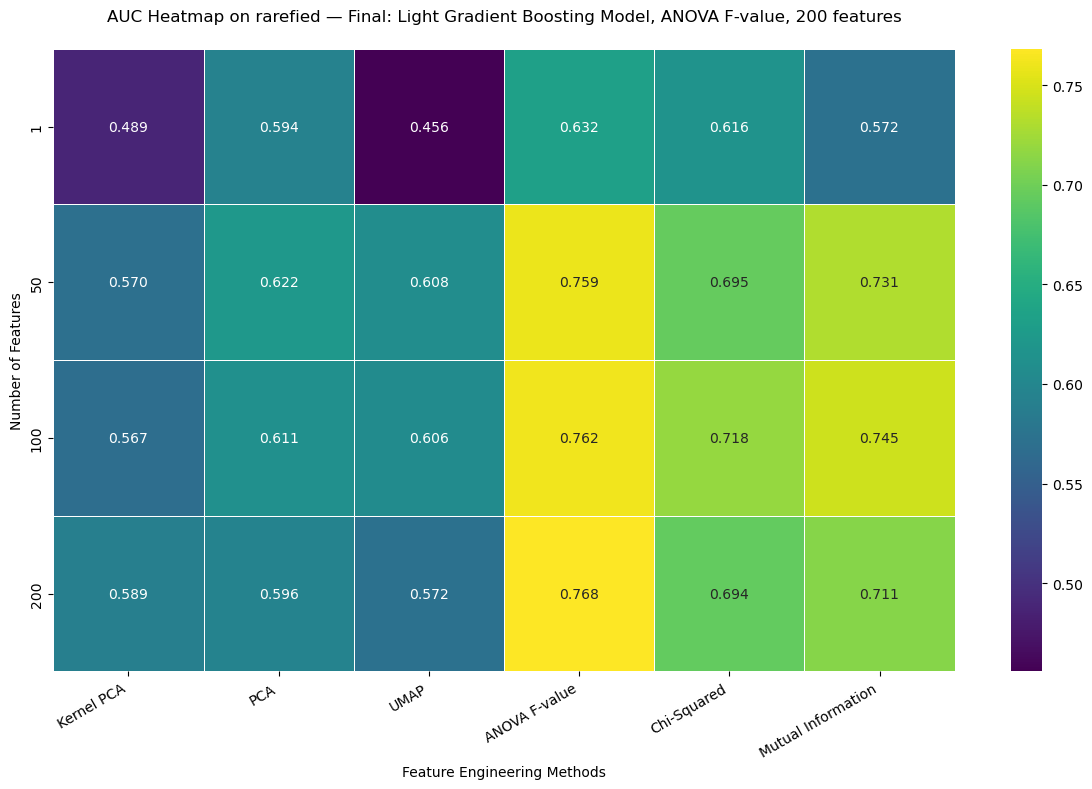

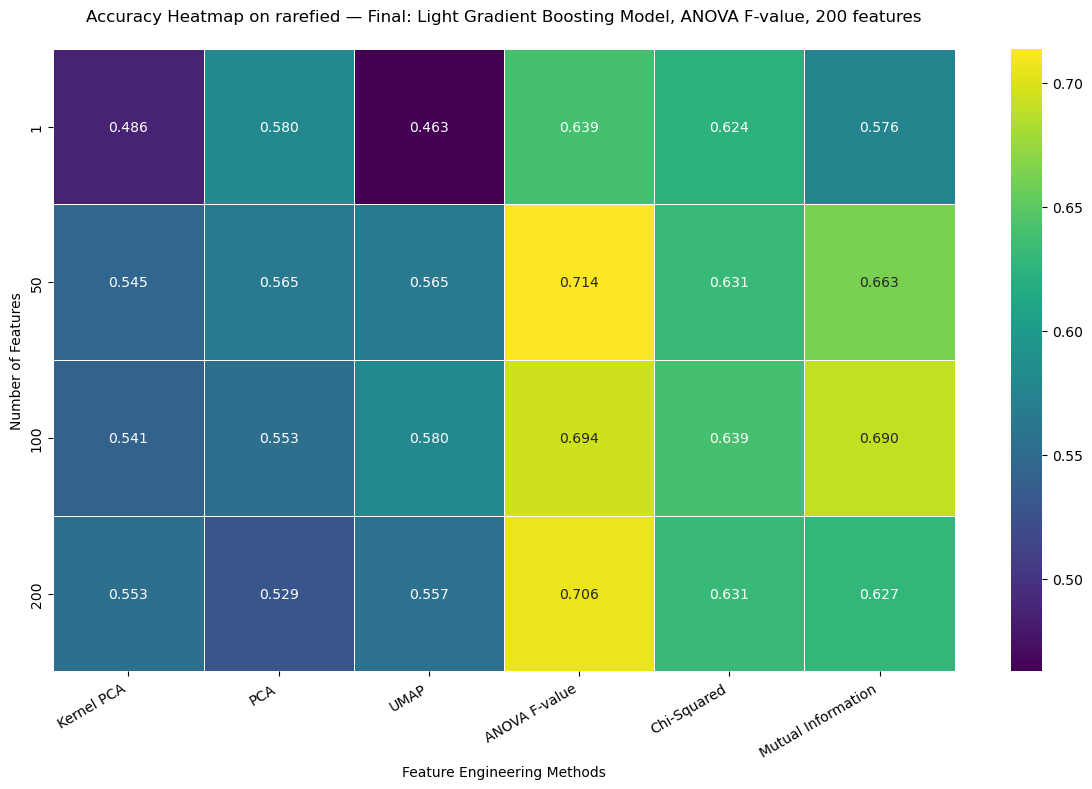

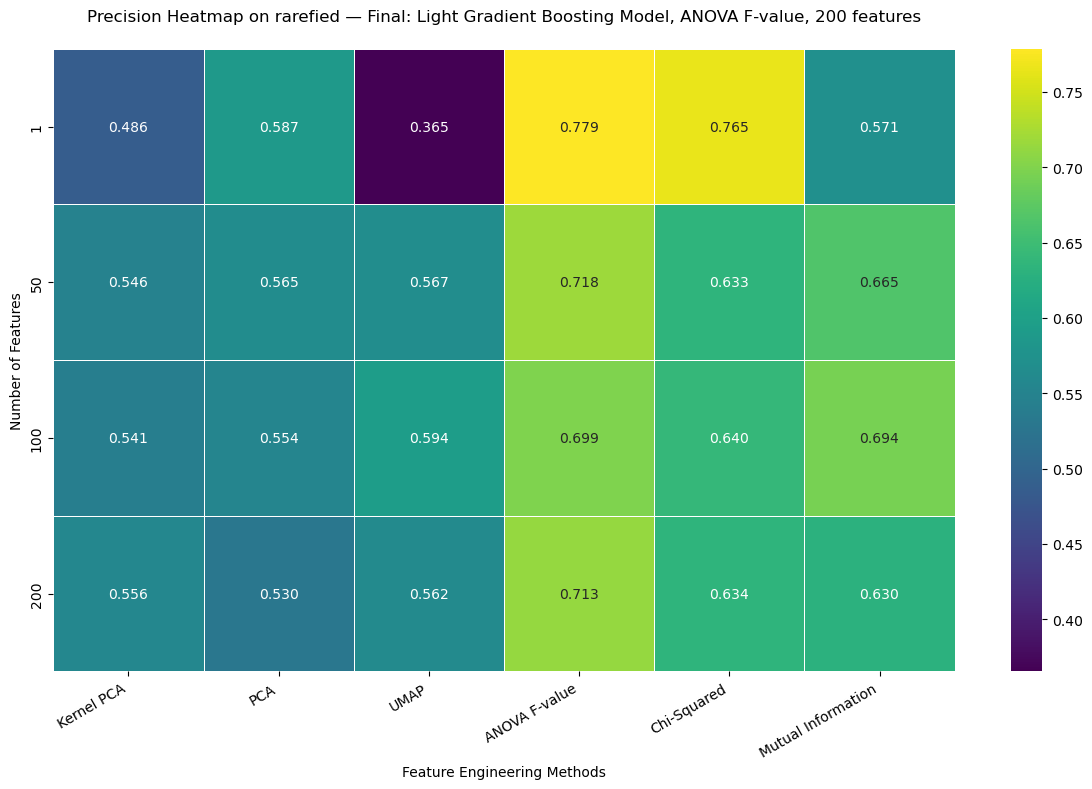

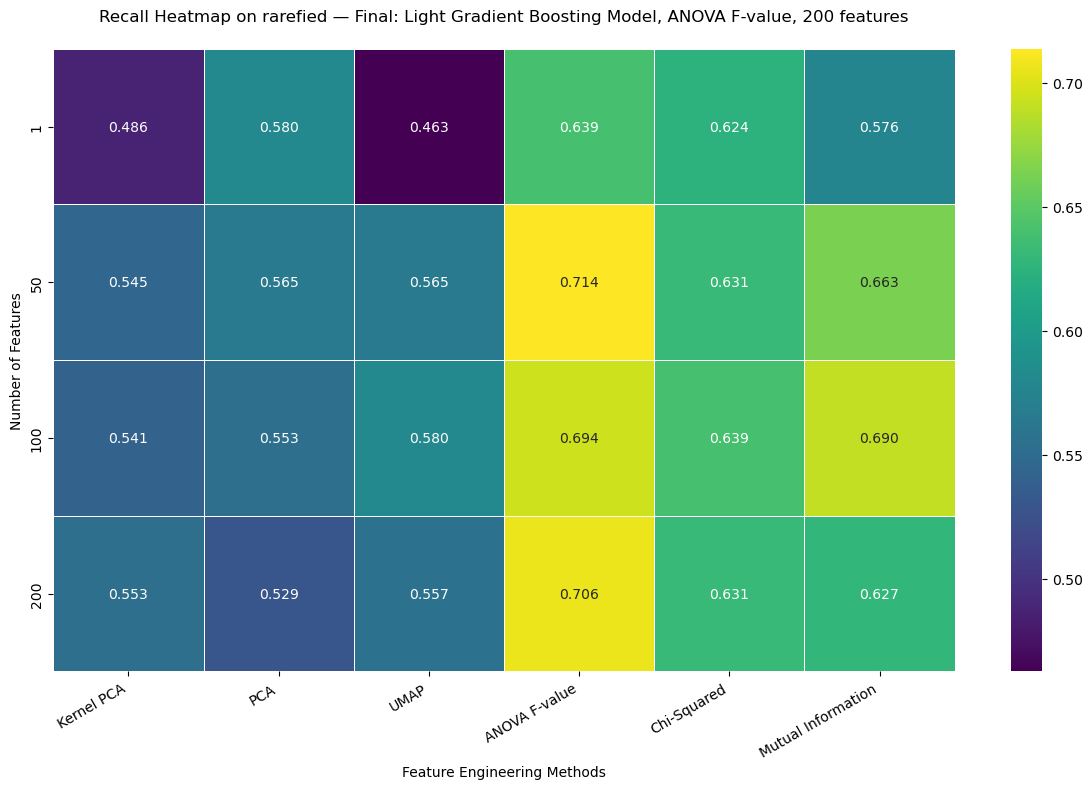

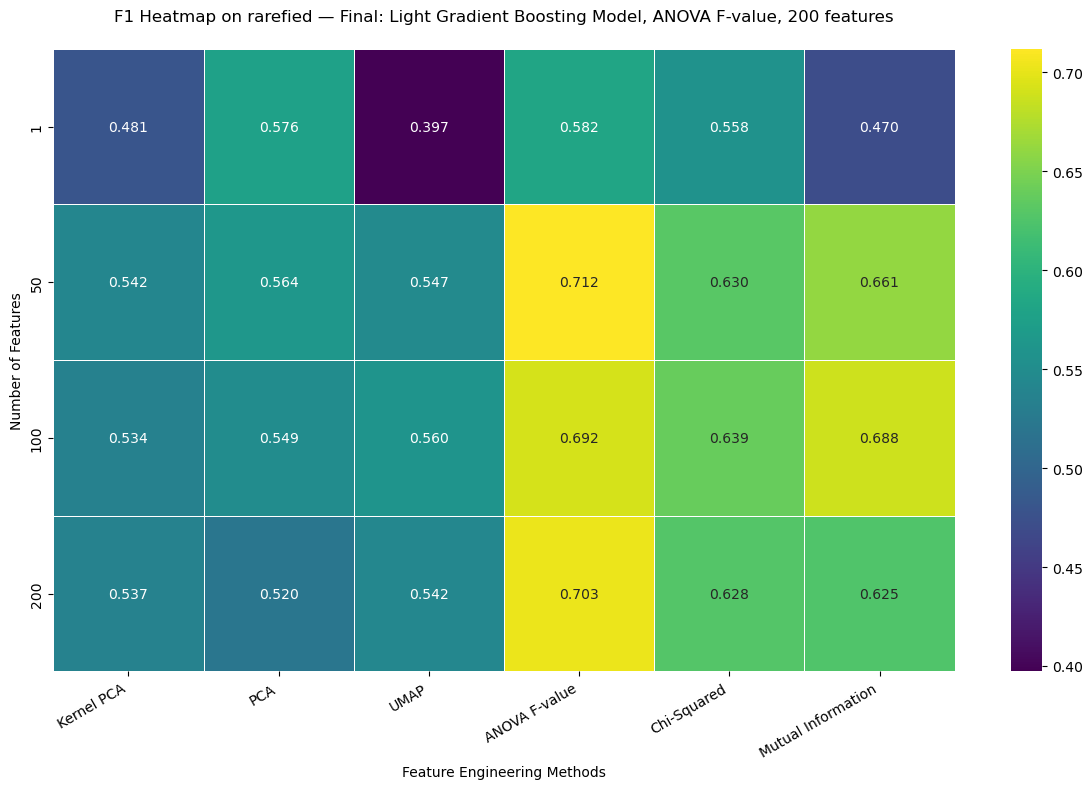

In [9]:
plot_heatmap(df_rarefied, "rarefied")

### Heatmaps -- CLR

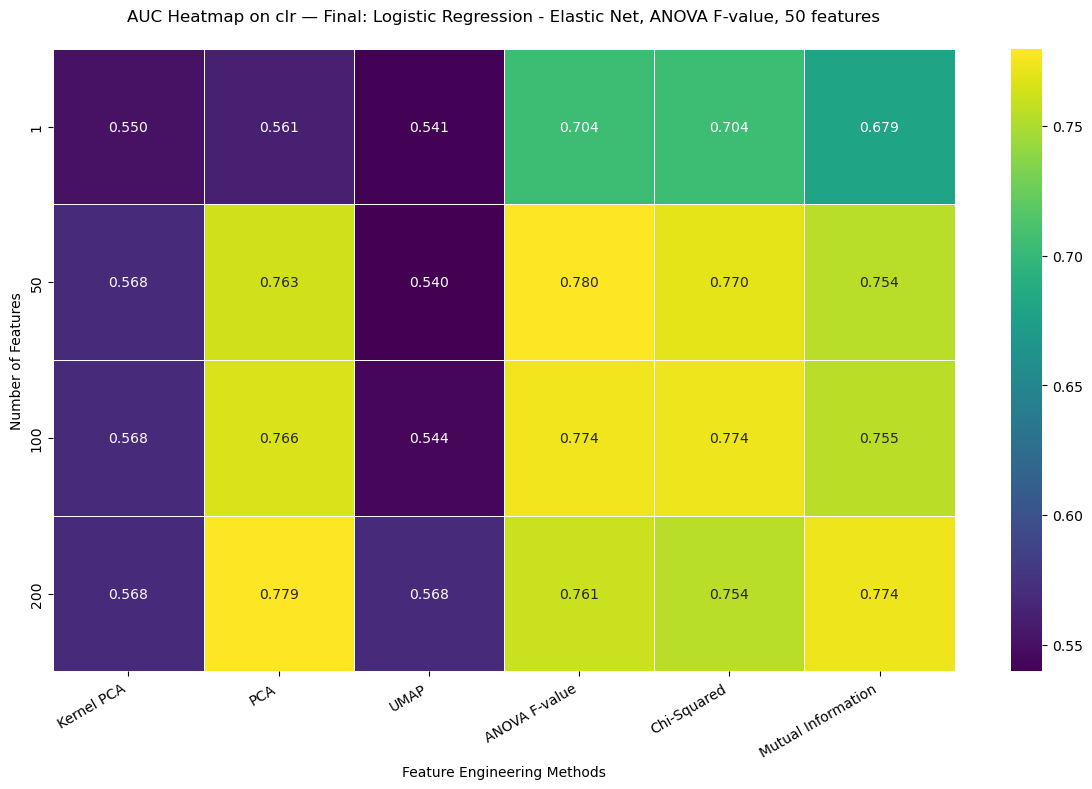

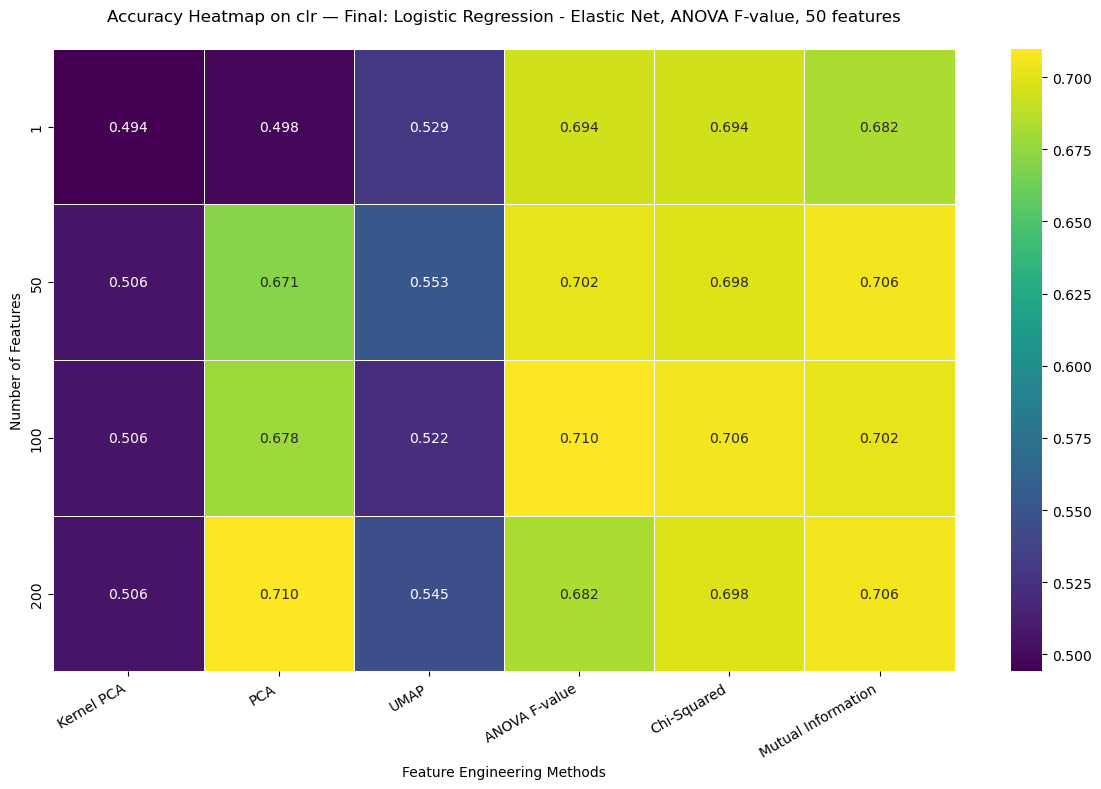

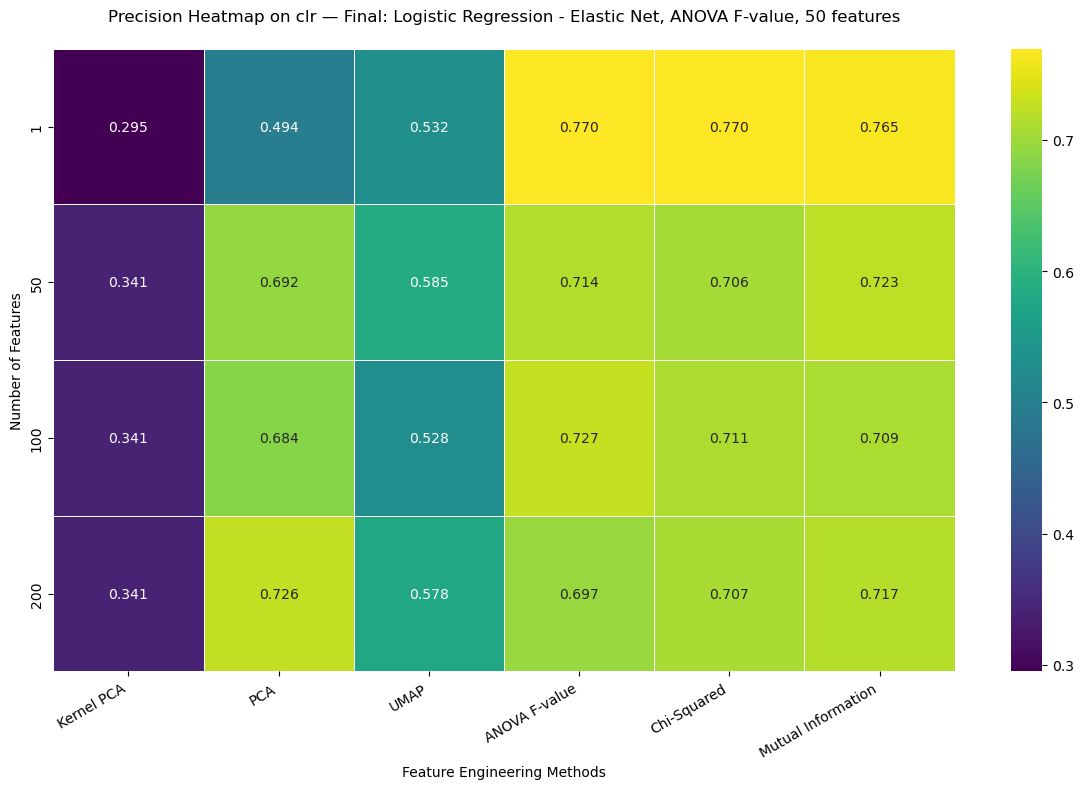

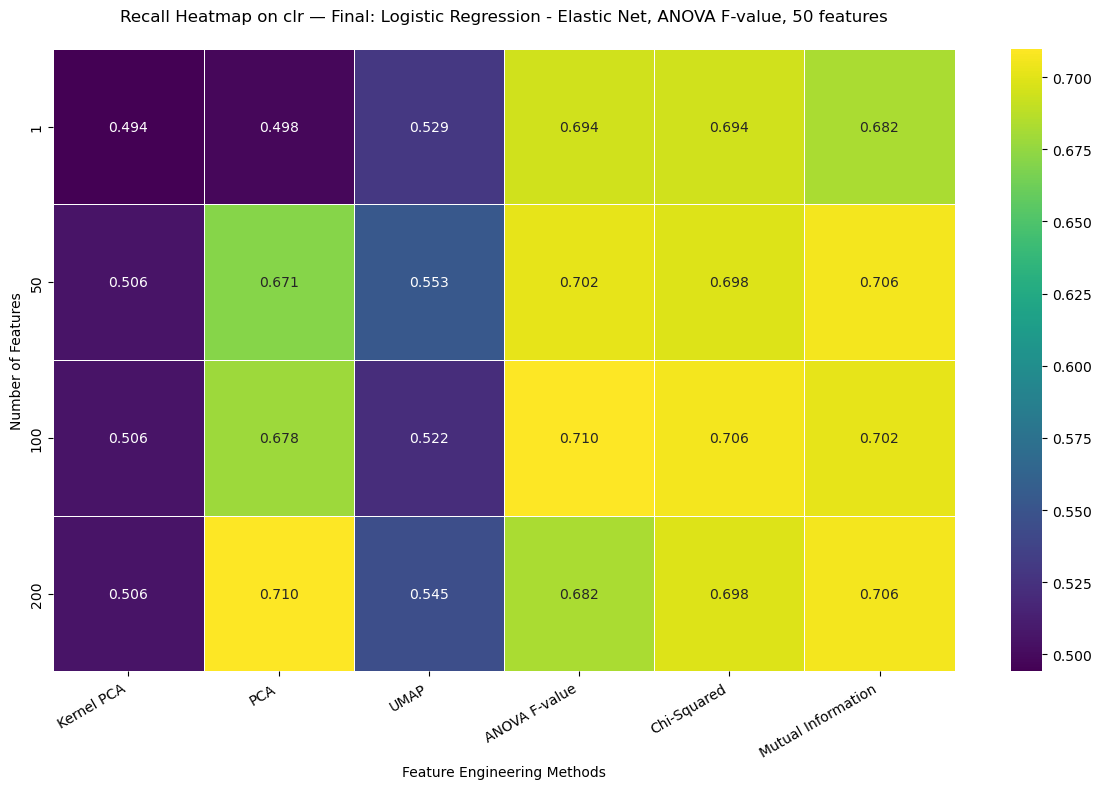

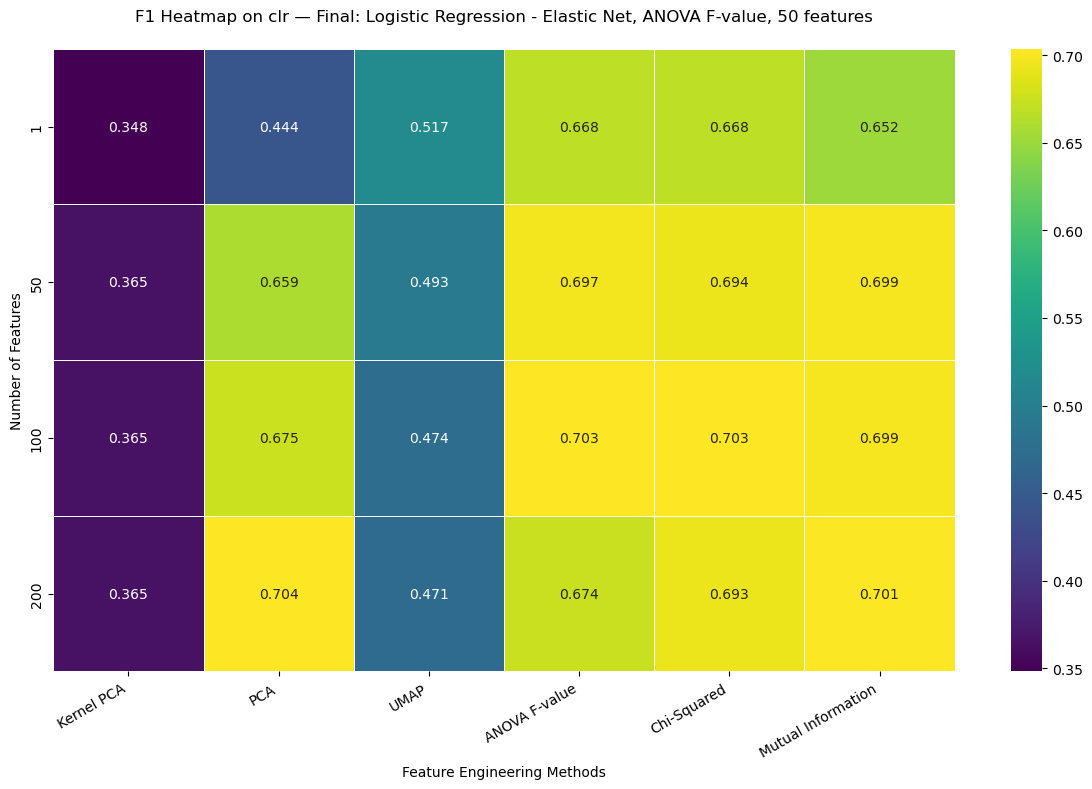

In [10]:
plot_heatmap(df_clr, "clr")

### Method Comparison Plotting Function

In [11]:
def plot_metric_trends(df, dataset_name, best_model_name):
    best = feature_eng_outputs[dataset_name]["best_method"]
    best_method = best["method"]
    best_k = best["n_features"]

    df_plot = df.reset_index()

    # excluding non-numeric rows
    df_plot = df_plot[df_plot["# Features"].str.isnumeric()]
    df_plot["# Features"] = df_plot["# Features"].astype(int)

    metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    feature_counts = sorted(df_plot["# Features"].unique())

    for metric in metrics:
        sns.set_palette("tab10")
        plt.figure(figsize=(12, 5))

        sns.lineplot(
            data=df_plot,
            x="# Features",
            y=metric,
            hue="Method",
            style="Type",
            markers=True,
            dashes=False
        )

        baseline_value = df.xs(("All Features", "Baseline", best_model_name))[metric]
        plt.axhline(
            y=baseline_value,
            linestyle="--",
            color="red",
            label="Baseline – All Features"
        )

        plt.xticks(feature_counts)
        plt.xlim(min(feature_counts) - 5, max(feature_counts) + 5)

        title = (
            f"{metric} Trends on {dataset_name} — "
            f"Final: {best_model_name}, {best_method}, {best_k} features"
        )
        plt.title(title, pad=20)
        plt.xlabel("Number of Features")
        plt.ylabel(metric)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Methods")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()

        visuals_dir = clr_visuals_dir if dataset_name == "clr" else rarefied_visuals_dir
        filename = f"{dataset_name}_trend_{metric.lower()}_{best_model_name.replace(' ', '')}.png"
        plt.savefig(os.path.join(visuals_dir, filename))
        plt.show()


### Feature Engineering Method Comparison — Rarefaction

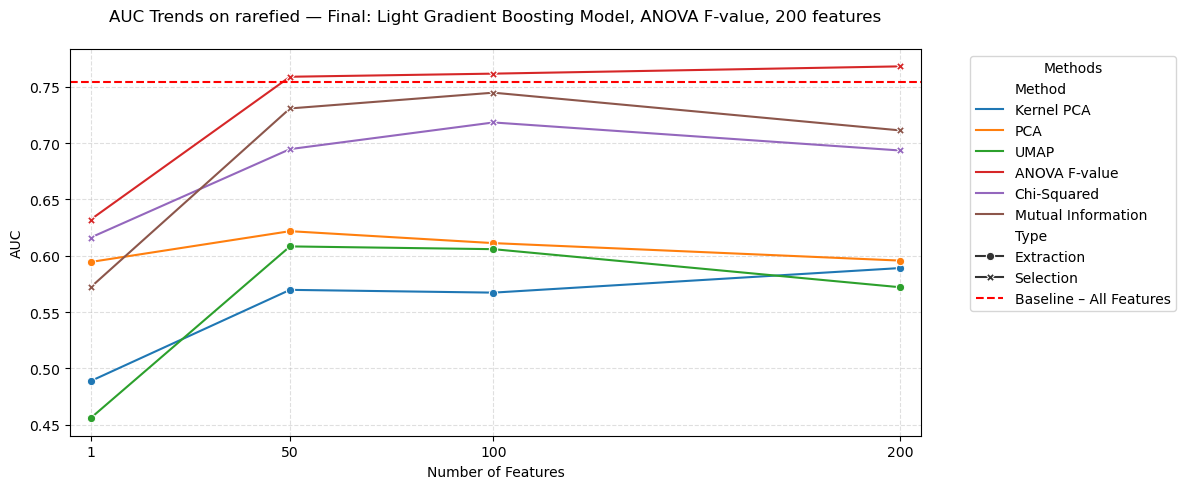

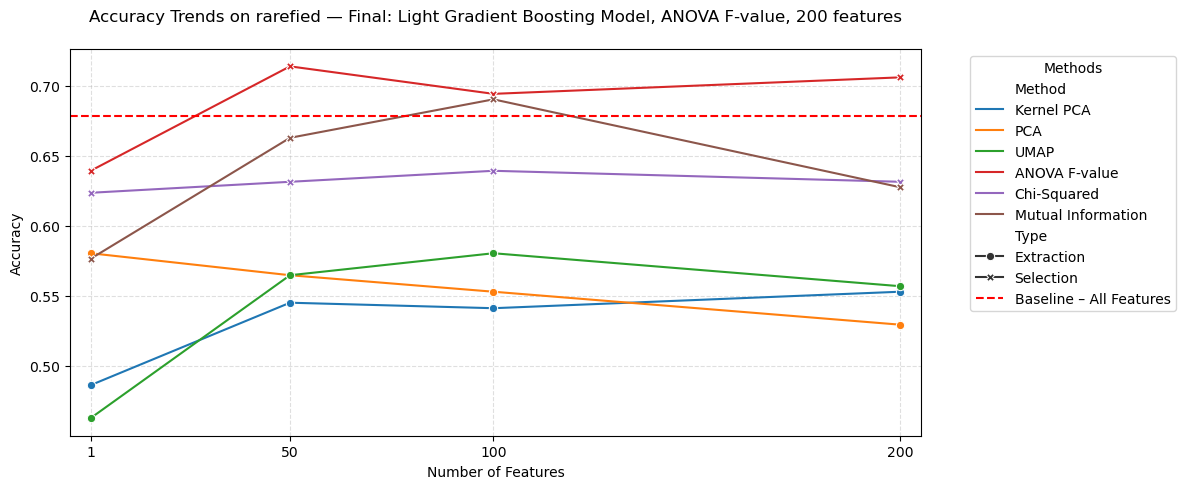

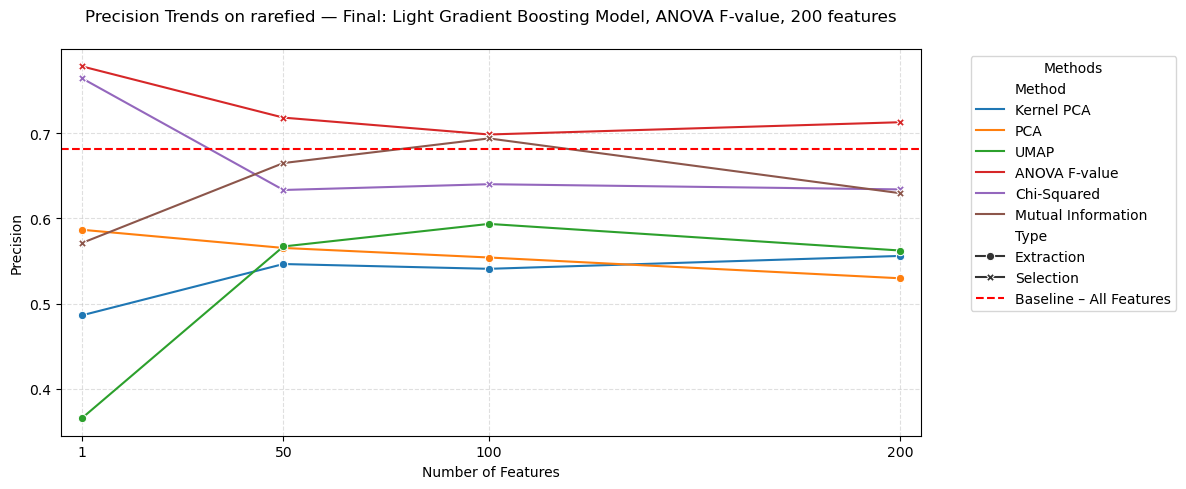

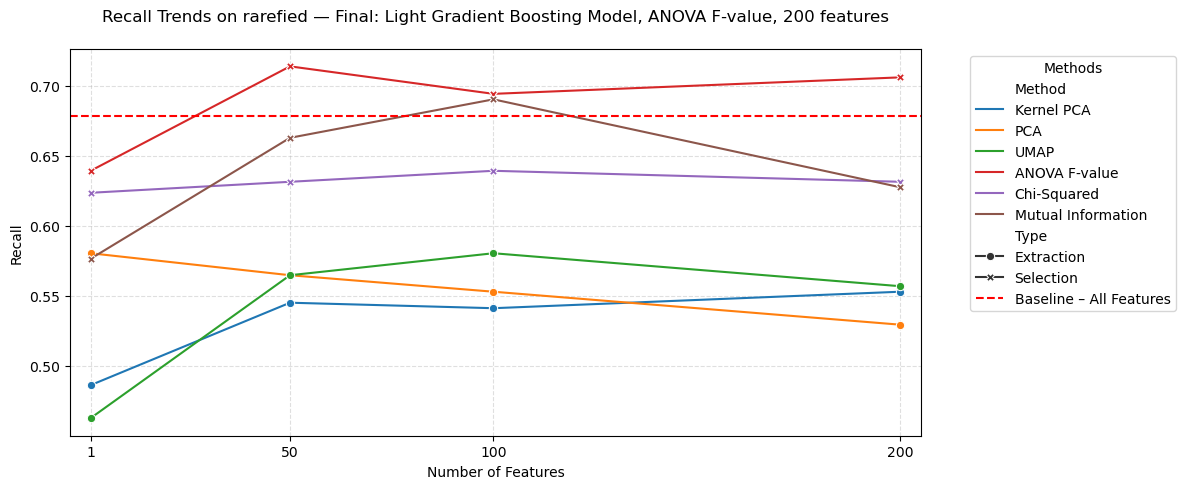

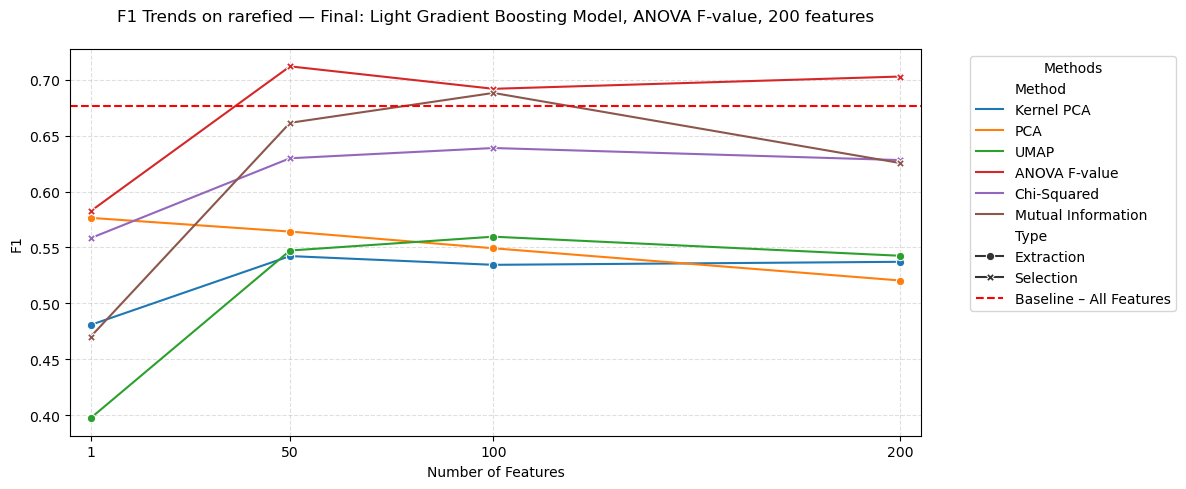

In [12]:
best_model_name = best_models_dict["rarefied"]["best_model"]
plot_metric_trends(df_rarefied, "rarefied", best_model_name)

### Feature Engineering Method Comparison — CLR

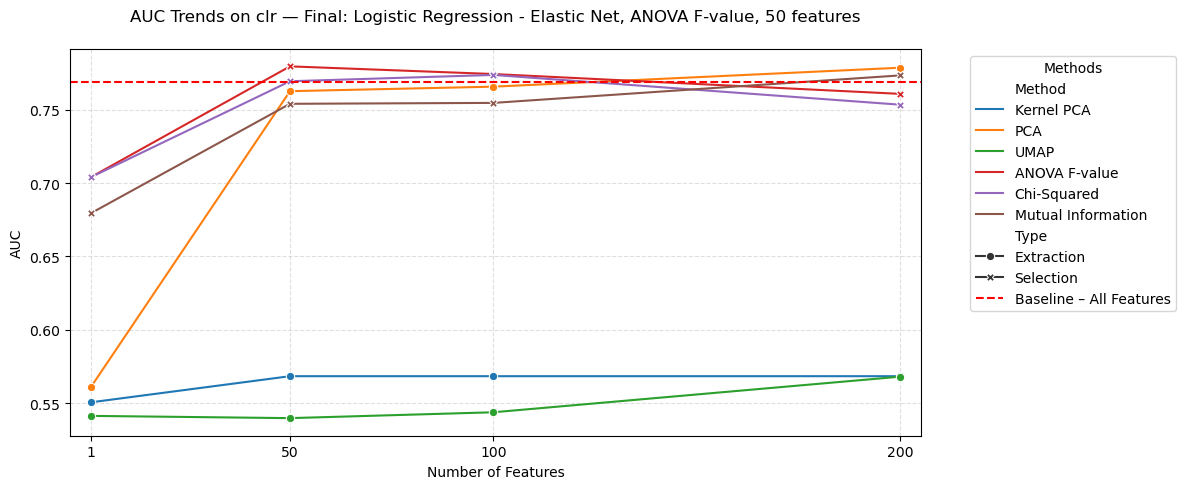

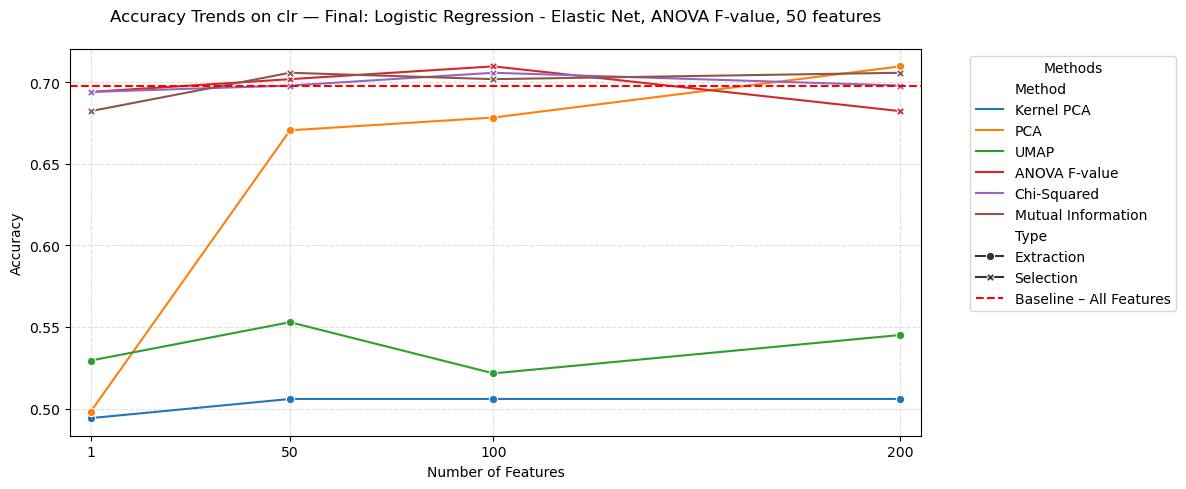

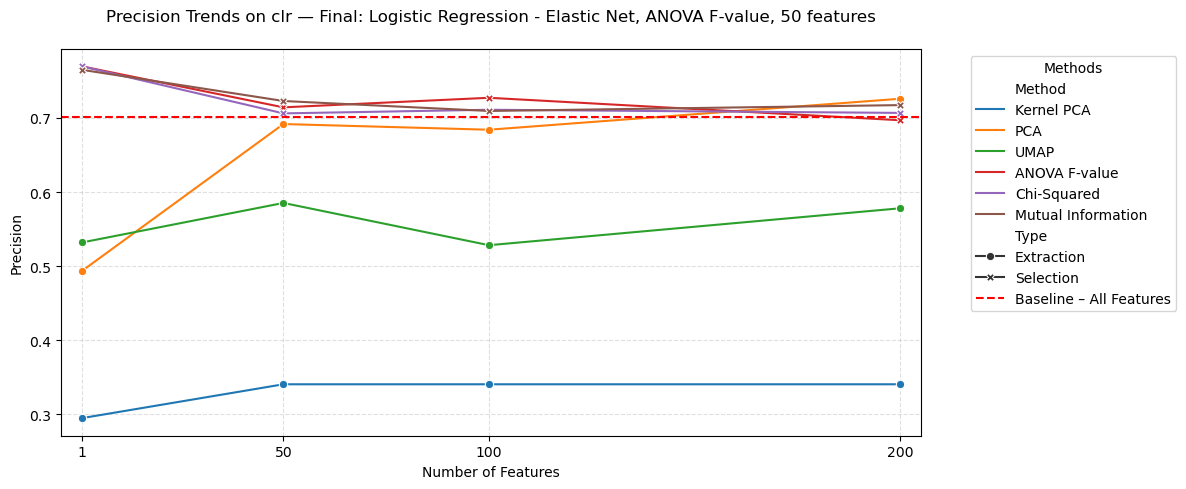

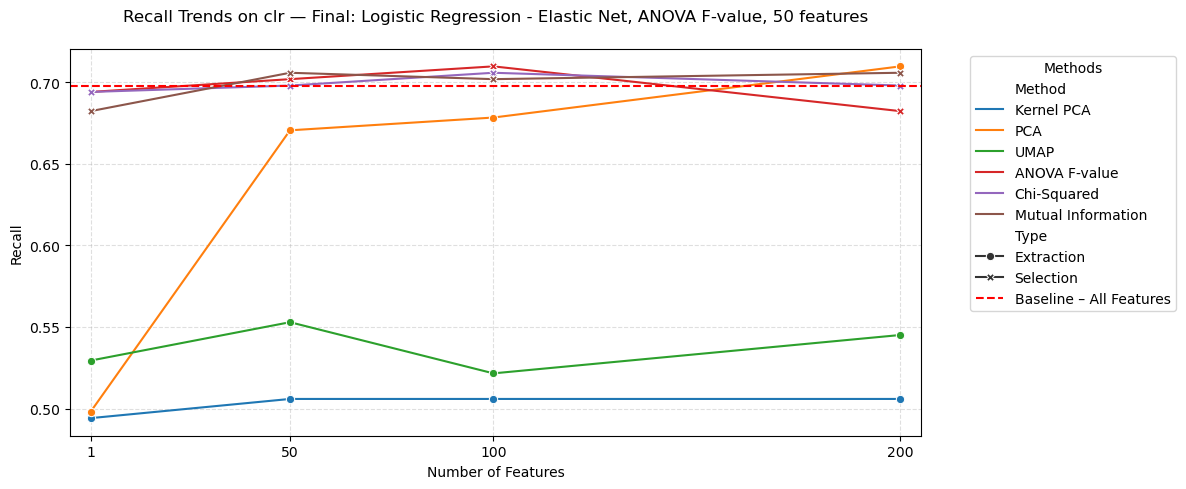

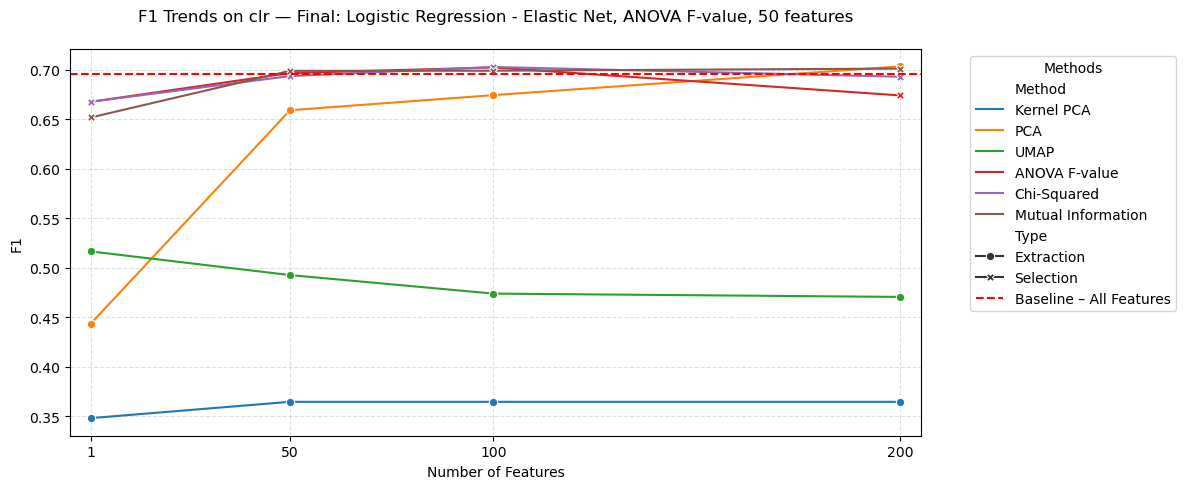

In [13]:
best_model_name = best_models_dict["clr"]["best_model"]
plot_metric_trends(df_clr, "clr", best_model_name)

### ROC Curve

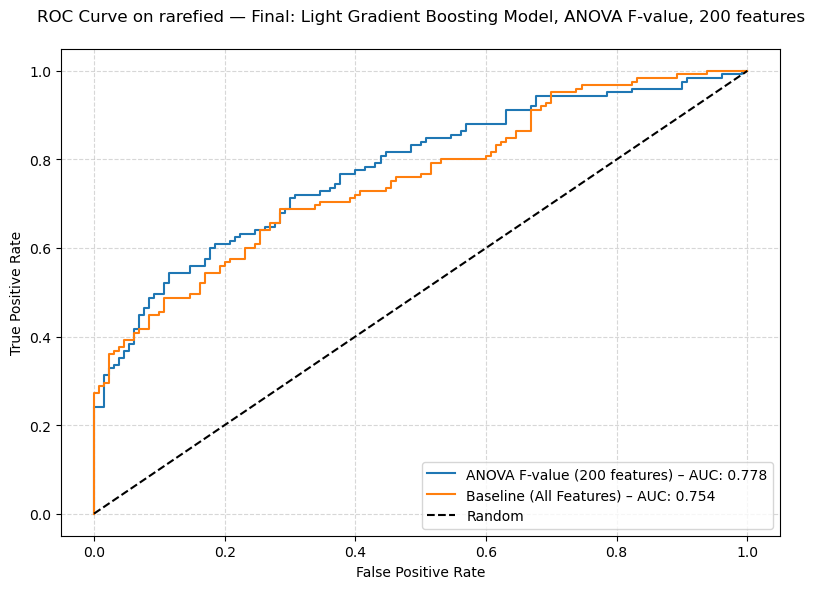

ROC curve saved to ./results/visuals/rarefied/rarefied_roc_curve_LightGradientBoostingModel.png


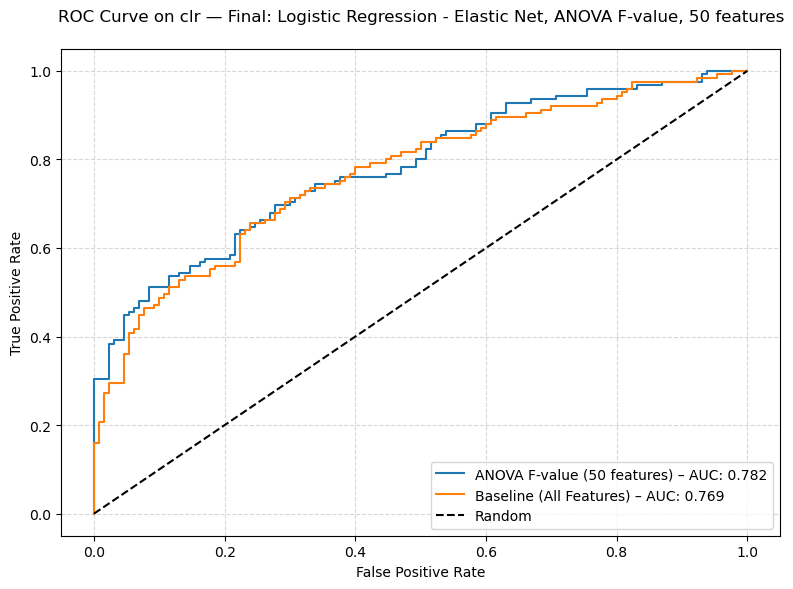

ROC curve saved to ./results/visuals/clr/clr_roc_curve_LogisticRegressionElasticNet.png


In [14]:
def plot_roc_curve(result, dataset_name):
    y_test = result["y_test"]
    baseline_probs = result["baseline_probs"]

    best = result["best_method"]
    best_probs = best["y_probs"]
    best_method = best["method"]
    best_k = best["n_features"]
    best_model_name = result["best_model_name"]

    fpr_baseline, tpr_baseline, _ = roc_curve(y_test, baseline_probs)
    auc_baseline = auc(fpr_baseline, tpr_baseline)

    fpr_best, tpr_best, _ = roc_curve(y_test, best_probs)
    auc_best = auc(fpr_best, tpr_best)

    # plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_best, tpr_best, label=f"{best_method} ({best_k} features) – AUC: {auc_best:.3f}")
    plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline (All Features) – AUC: {auc_baseline:.3f}")
    plt.plot([0, 1], [0, 1], "k--", label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    title = (
        f"ROC Curve on {dataset_name} — "
        f"Final: {best_model_name}, {best_method}, {best_k} features"
    )
    plt.title(title, pad=20)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    # saving
    visuals_dir = clr_visuals_dir if dataset_name == "clr" else rarefied_visuals_dir
    filename = f"{dataset_name}_roc_curve_{best_model_name.replace(' ', '').replace('-', '')}.png"
    out_path = os.path.join(visuals_dir, filename)

    plt.savefig(out_path)
    plt.show()
    print(f"ROC curve saved to {out_path}")


for ds in dataset_names:
    plot_roc_curve(feature_eng_outputs[ds], ds)